# Visualizing BERT embeddings from Wikipedia, EURLEX and Privacy Policies using t-SNE

In this notebook, we probe the BERT sequence embeddings of texts from the general, legal and privacy domains. These documents come from Wikipedia, EURLEX and privacy policies respectively. We go about this by first computing BERT embeddings and then compute t-SNE dimensionality reduction for plotting.

First we download data from Wikipedia, EURLEX and Privacy Policies. After that, we load this data into memory.

In [1]:
import os
import random

import matplotlib
import pandas as pd
import requests
import torch
import umap
from datasets import load_dataset
from plotnine import (
    aes,
    annotate,
    element_blank,
    element_rect,
    element_text,
    facet_wrap,
    geom_point,
    ggplot,
    ggtitle,
    guides,
    guide_legend,
    scale_color_manual,
    scale_size_continuous,
    theme,
    theme_bw,
)
from sklearn.manifold import TSNE
from tqdm import tqdm
from transformers import AutoModel, AutoTokenizer

%matplotlib inline
matplotlib.rc("text", usetex=True)

In [2]:
# download and load datasets
eurlex = load_dataset("eurlex")
wikipedia = load_dataset("wikipedia", "20220301.en")

# download privacy policies if they are not present
privacy_file = os.path.join("data", "policies.jsonl")
if not os.path.exists(privacy_file):
    privacy = requests.get("https://drive.switch.ch/index.php/s/pA71WgN8zf2ALbW/download")
    with open(privacy_file, "wb") as output_file_stream:
        output_file_stream.write(privacy.content)
        
# load privacy file as dataset
privacy = load_dataset("json", data_files=privacy_file)

No config specified, defaulting to: eurlex/eurlex57k
Reusing dataset eurlex (/home/shankar/.cache/huggingface/datasets/eurlex/eurlex57k/1.1.0/d2fdeaa4fcb5f41394d2ed0317c8541d7f9be85d2d601b9fa586c8b461bc3a34)


  0%|          | 0/3 [00:00<?, ?it/s]

Reusing dataset wikipedia (/home/shankar/.cache/huggingface/datasets/wikipedia/20220301.en/2.0.0/aa542ed919df55cc5d3347f42dd4521d05ca68751f50dbc32bae2a7f1e167559)


  0%|          | 0/1 [00:00<?, ?it/s]

Using custom data configuration default-7c3a3e54152170eb
Reusing dataset json (/home/shankar/.cache/huggingface/datasets/json/default-7c3a3e54152170eb/0.0.0/a3e658c4731e59120d44081ac10bf85dc7e1388126b92338344ce9661907f253)


  0%|          | 0/1 [00:00<?, ?it/s]

Then we load the `BERT` model and its tokenizer:

In [3]:
# load model and tokenizer and send model to the GPU (assuming we have one)
model = AutoModel.from_pretrained("bert-base-uncased").to("cuda:0")
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Then we compute the corpus embeddings given a token upper limit of 1,000,000 tokens.

In [4]:
def get_corpus_embeddings(corpus, text_column="text", limit=1000000, seed=42):
    # initialize variables and shuffle corpus
    corpus_embeddings = []
    indices = list(range(len(corpus)))
    random.seed(seed)
    random.shuffle(indices)
    count = 0
    
    # loop over corpus text column
    with tqdm(indices, desc="Embed and count tokens") as tqdm_iterator:
        for index in tqdm_iterator:
            # tokenize input
            input_ids = tokenizer.encode(corpus[index][text_column],
                                         truncation=True, return_tensors="pt").to("cuda:0")
            
            # add tokens to global counter
            # NOTE: we minus 2 to account for the [CLS] and [SEP] tokens
            count += (input_ids.shape[1] - 2)

            # update tqdm display
            tqdm_iterator.set_postfix_str("tokens: %s/%s" % (count, limit))
            
            # check if count satisfies limit
            if count >= limit:
                break
            else:
                outputs = model(input_ids)
                cls_embedding = outputs.last_hidden_state.detach()[:, 0, :]
                corpus_embeddings.append(cls_embedding)
        else:
            raise ValueError("Unable to satisfy %s token limit" % limit)

    # concatenate list into single tensor
    return torch.cat(corpus_embeddings)

We compile everything together and compute t-SNE embeddings.

In [5]:
# compute corpus embeddings
wikipedia_embeddings = get_corpus_embeddings(wikipedia["train"])
eurlex_embeddings = get_corpus_embeddings(eurlex["train"])
privacy_embeddings = get_corpus_embeddings(privacy["train"])

Embed and count tokens:  39%|██▋    | 1961/5000 [00:33<00:52, 57.87it/s, tokens: 1000117/1000000]


In [6]:
# compute lengths of each corpus
wikipedia_length = wikipedia_embeddings.shape[0]
eurlex_length = eurlex_embeddings.shape[0]
privacy_length = privacy_embeddings.shape[0]

In [7]:
# concatenate everything into single tensor and domains
all_embeddings = torch.cat([wikipedia_embeddings, eurlex_embeddings, privacy_embeddings])
domains = ["Wikipedia"] * wikipedia_length + ["EURLEX"] * eurlex_length + ["Privacy"] * privacy_length

# shuffle everything for posterity
indices = list(range(all_embeddings.shape[0]))
random.seed(42)
random.shuffle(indices)
all_embeddings = all_embeddings[indices]
domains = [domains[index] for index in indices]

In [8]:
# compute t-sne embeddings of all corpus embeddings
tsne_embeddings = TSNE(n_components=2, learning_rate="auto", init="random",
                       random_state=42).fit_transform(all_embeddings.cpu().numpy())

In [9]:
# compute umap embeddings of all corpus embeddings
mapper = umap.UMAP(n_components=2, random_state=42).fit(all_embeddings.cpu().numpy())
umap_embeddings = mapper.transform(all_embeddings.cpu().numpy())

In [10]:
# combine everything into dataframe with mapped domains
tsne_df = pd.DataFrame({"x": tsne_embeddings[:, 0], "y": tsne_embeddings[:, 1],
                        "method": "t-SNE",
                        "domain": domains,
                        "size": 10})
umap_df = pd.DataFrame({"x": umap_embeddings[:, 0], "y": umap_embeddings[:, 1],
                        "method": "UMAP",
                        "domain": domains,
                        "size": 0.1})
df = pd.concat([tsne_df, umap_df])
df = df.assign(domain = pd.Categorical(df["domain"], ["Wikipedia", "EURLEX", "Privacy"]))
df = df.assign(method = pd.Categorical(df["method"], ["t-SNE", "UMAP"]))

In [11]:
df

,x,y,method,domain,size
0,-8.083041,-11.555822,t-SNE,Wikipedia,10.0
1,-28.892263,32.691402,t-SNE,Privacy,10.0
2,5.796731,-27.338371,t-SNE,Wikipedia,10.0
3,-1.875435,12.129666,t-SNE,Wikipedia,10.0
4,50.941696,10.574926,t-SNE,EURLEX,10.0
...,...,...,...,...,...
7610,13.531553,6.068759,UMAP,Wikipedia,0.1
7611,3.703976,0.108608,UMAP,Privacy,0.1
7612,14.014095,5.008127,UMAP,Wikipedia,0.1
7613,15.224261,8.522521,UMAP,Wikipedia,0.1


Finally, we plot the t-SNE embeddings.

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


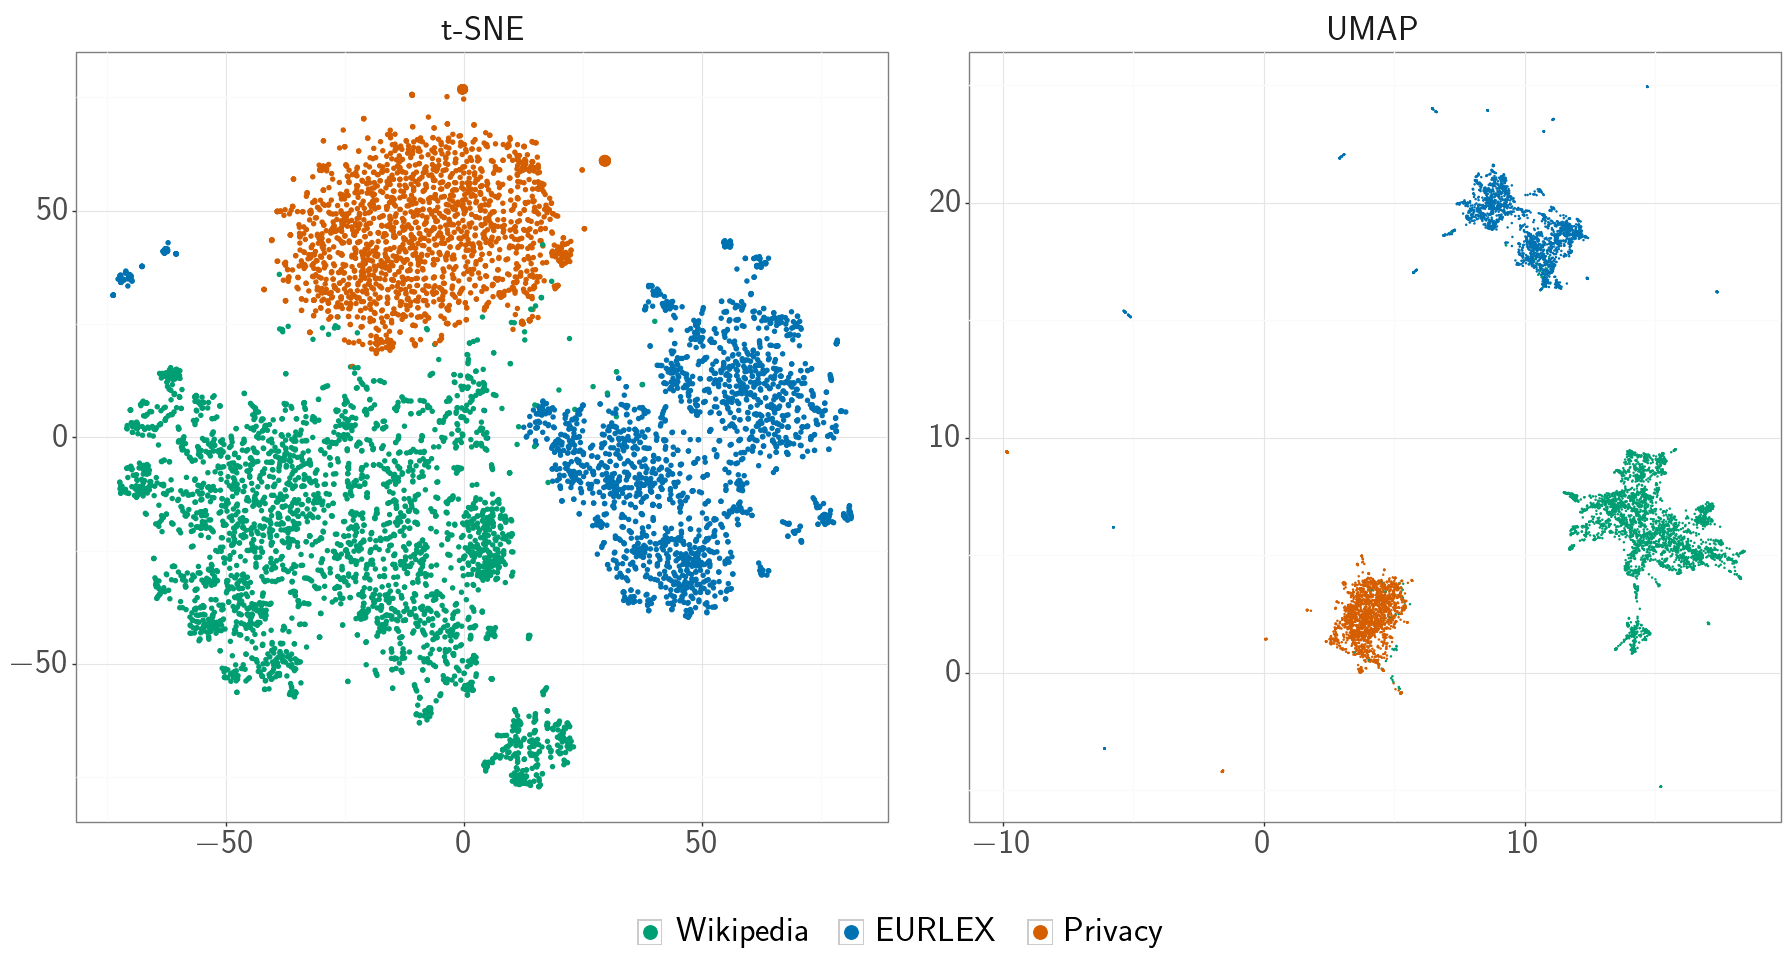

In [12]:
# plot ggplot object
(
    ggplot(aes(x="x", y="y", color="domain"), df)
    + geom_point(aes(size="size"))
    + facet_wrap("method", scales="free")
    + theme_bw()
    + theme(axis_title_x=element_blank(), axis_title_y=element_blank(), figure_size=(22, 10),
            text=element_text(size=25), legend_text=element_text(margin={"l": 10}),
            legend_position=(0.5, 0), legend_direction="horizontal", legend_title=element_blank(),
            legend_entry_spacing=20, legend_key=element_rect(fill="white"), strip_background=element_blank(),
            subplots_adjust={"wspace":0.1})
    + scale_color_manual(values=["#009e73", "#0072b2", "#d55e00"])
    + scale_size_continuous(range=(0.01,1.2), guide=None)
    + guides(color=guide_legend(override_aes={"size": 5}))
).draw();